# Part II: Bimodal, One-dimensional distribution

## Task 1
After running the code below, comment on the Stan output.
 1. Use the Rhat value to comment on whether the Markov chains converged properly or not. Explain your answer.
 2. What are the total number of samples and the effective number of samples? Are these values good or not?

In [1]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas
import seaborn

%matplotlib inline

In [2]:
# The Stan model. In this case we have no data. Instead we specify an
# unnormalized target distribution directly and use Stan to sample from it.
# Running this cell compiles the Stan model, which takes some time.

stan_data = {}

stan_code = """
parameters {
    real x;
}

model {
    target += log_sum_exp(normal_lpdf(x | -4, 0.5), normal_lpdf(x | 4, 1));
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1da4d42e8374c1eb37bc42dde174418 NOW.


In [3]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

parameters = ['x']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_c1da4d42e8374c1eb37bc42dde174418.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x    2.0    2.46   3.58  -4.58  -1.04    3.6   4.44   5.79      2   4.24

Samples were drawn using NUTS at Tue Dec 17 12:14:35 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Now, comment on the Stan output above.

1. *Use the Rhat value to comment on whether the Markov chains converged properly or not. Explain your answer.*

The Rhat value for x is equal to 4.24, this suggests that the Markov chains didn't converge properly and are not mixing well.


2. *What are the total number of samples and the effective number of samples? Are these values good or not?*

The value of n_eff is equal to 2 which is considerably smaller since we started with 4000 samples, we can conclude that the samples are not independent and can't be reliable

## Task 2
Run the code below and use the plots to answer the following questions.

1. *Are the samples correlated or reasonably independent?*

Yes, the samples seem to be correlated based on the autocorrelation graph.


2. *What information does the pair plot provide?*

We have one variable x, hence, the result is a histogram of the data rather than the pair plot.

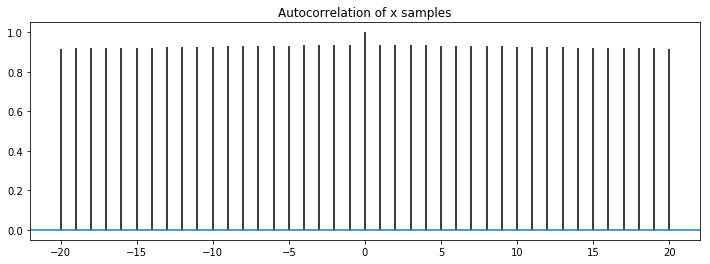

In [4]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


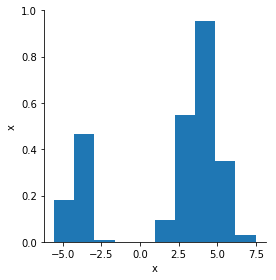

In [5]:
# Make pair plot of the posteriors over all parameters of the model.
df = pandas.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## Task 3
Since the target distribution is 1-dimensional we can visualize it. This will not be the case with higher-dimensional distributions.

Run the code below and answer the following question.

1. *Are the Stan samples distributed according to the target distribution?*

Yes, the samples seem to land on both modes of the target distribution, but the expected split of 50% for each mode was not acheived and it's a 25% - 75% split instead.


2. *Relate your answer to question 1 to what you observed from the autocorrelation plot in Task 2.*
There are four Markov chains, and the split was 25/75, this would mean that in each chain, Stan modeled from one peak and it's really hard to move from one mode to another given that the mass between the two is really small. As a result, the samples from each chain is highly correlated which explains the finding of the autocorrelation graph.

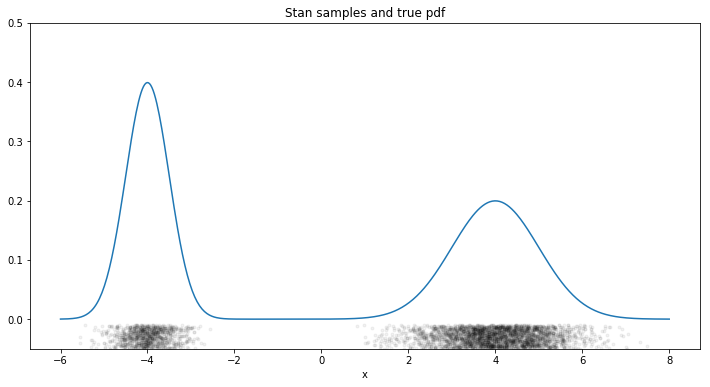

Split of samples between the two modes (should be about 0.5): 0.25


In [6]:
# Plot the 4000 Stan samples below the 1-dimensional pdf.
def p(x):
    return (stats.norm.pdf(x, -4, 0.5) + stats.norm.pdf(x, 4, 1)) / 2

plt.figure(figsize=(12, 6))
plot_x = np.linspace(-6, 8, 500)
plt.plot(plot_x, p(plot_x))

plt.plot(
    samples['x'],
    stats.uniform.rvs(loc=-0.05, scale=-0.01+0.05, size=len(samples['x'])),
    'k.', alpha=0.05)
plt.ylim(-0.05, 0.5)
plt.xlabel('x')
plt.title('Stan samples and true pdf')
plt.show()

x = np.mean(samples['x'] < -1)
print('Split of samples between the two modes (should be about 0.5):', min(x, 1-x))